In [1]:
# Things we'll learn
# Image Folder
# Scheduler
# Transfer Learning

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import os
import copy

# Import Data
data_dir = 'data/hymenoptera_data'
sets = ['train', 'val']

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ]),
  'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ]),
}

image_datasets = {
  x: datasets.ImageFolder(
    os.path.join(data_dir, x), 
    data_transforms[x]
  ) for x in sets}
dataloaders = {
  x: torch.utils.data.DataLoader(
    image_datasets[x], 
    batch_size=4, 
    shuffle=True, 
    num_workers=0
  ) for x in sets}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes)
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


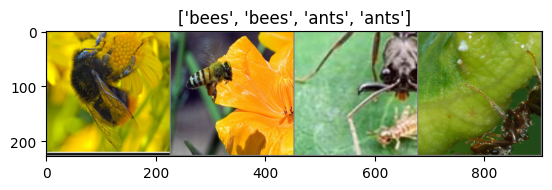

In [2]:
def imshow(inp, title):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  inp = std * inp + mean # Normalize the image
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  plt.title(title)
  plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
        
      running_loss = 0.0
      running_corrects = 0
      
      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Update running loss and corrects
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step() # Every epoch update the learning rate
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      
      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      
      # Deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
    print()
    
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # Load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [19]:
# Finetune the model
# Load a pre-trained model and reset final fully connected layer

model = models.resnet18(pretrained=True)
# Print the Final Fully Connected Layer
print(model.fc.in_features)
print(model.state_dict().keys())
print(model.conv1)

# Optional to Freeze the Layers
# for param in model.parameters():
#   param.requires_grad = False

# Replace the Final Fully Connected Layer
# Newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

d:\Belajar\AI Arifin\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Belajar\AI Arifin\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias

In [22]:
torch.save(model.state_dict(), 'hymenoptera_model_state_dict.pth')